In [1]:
# copy the lib file in the working directory and load it
from shutil import copyfile
copyfile('target/release/libising_triangular.so', 'ising_triangular.so')
import ising_triangular as it

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import threading
import time

In [3]:
n = 100
L = 64

xs = [np.random.randint(0, 2, size=(L, L), dtype=np.int32) * 2 - 1 for i in range(n)]
es = [it.energy(xs[i]) for i in range(n)]
ts = np.linspace(1.5, 5, n)

code pour faire un plot dynamique

<IPython.core.display.Javascript object>


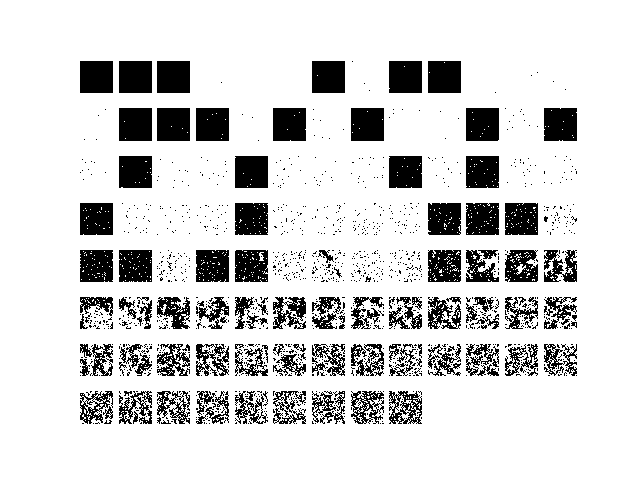

In [4]:
w = int(np.ceil(np.sqrt(1.5 * n)))
        
fig = plt.figure()
axes = [fig.add_subplot(int(np.ceil(n / w)), w, i + 1) for i in range(n)]

def plot(i):
    axes[i].set_axis_off()
    return axes[i].imshow(xs[i], cmap='gray', vmin=-1, vmax=1)

imgs = [plot(i) for i in range(n)]

fig.canvas.draw()

def replot(xs):
    for i in range(n):
        imgs[i].set_data(xs[i])
    fig.canvas.draw()

definition d'une fonction pour mesurer le temps d'execution de potions de code

In [5]:
def top(text=None):
    now = time.time()
    if text:
        print("{} : {:.3f}s".format(text, now - top.past))
    top.past = now
    
top.past = time.time()

fonctions pour faire des sweeps en parallèle suivit de swaps

In [6]:
def sweep(k):
    def foo():
        es[k] += it.sweep(xs[k], ts[k])
    return foo

def sweep_swap():
    # start all the threads
    threads = [threading.Thread(target=sweep(i)) for i in range(n)]
    for t in threads:
        t.start()

    # wait threads to finish
    for t in threads:
        t.join()

    # performs swaps
    for _ in range(2 * n):
        [i, j] = np.random.choice(n, 2, replace=False)
        if np.random.uniform() < np.exp((es[i] - es[j]) * (1 / ts[i] - 1 / ts[j])):
            xs[i], xs[j] = xs[j], xs[i]
            es[i], es[j] = es[j], es[i]

In [7]:
top()
# thermalize
for _ in range(200):
    sweep_swap()

top('termalize')

m = 500
energy = np.zeros((m, n))
magnet = np.zeros((m, n))

for i in range(m):
    # create threads
    top()
    
    bs = 10
    energy_bin = np.zeros(n)
    magnet_bin = np.zeros(n)
    
    for _ in range(bs):
        sweep_swap()
        energy_bin += np.array(es) / (L * L)
        magnet_bin += np.array([np.sum(xs[j]) for j in range(n)]) / (L * L)
    
    energy[i] = energy_bin / bs
    magnet[i] = magnet_bin / bs

    top(str(i) + ' compute bin')
    
    if i % 5 == 0:
        replot(xs)
        top('plot')

termalize : 7.100s
0 compute bin : 0.378s
plot : 0.172s
1 compute bin : 0.390s
2 compute bin : 0.378s
3 compute bin : 0.382s
4 compute bin : 0.397s
5 compute bin : 0.390s
plot : 0.174s
6 compute bin : 0.395s
7 compute bin : 0.452s
8 compute bin : 0.383s
9 compute bin : 0.390s
10 compute bin : 0.393s
plot : 0.177s
11 compute bin : 0.500s
12 compute bin : 0.362s
13 compute bin : 0.383s
14 compute bin : 0.379s
15 compute bin : 0.378s
plot : 0.171s
16 compute bin : 0.379s
17 compute bin : 0.377s
18 compute bin : 0.382s
19 compute bin : 0.386s
20 compute bin : 0.378s
plot : 0.176s
21 compute bin : 0.405s
22 compute bin : 0.371s
23 compute bin : 0.389s
24 compute bin : 0.376s
25 compute bin : 0.372s
plot : 0.179s
26 compute bin : 0.396s
27 compute bin : 0.371s
28 compute bin : 0.397s
29 compute bin : 0.378s
30 compute bin : 0.402s
plot : 0.177s
31 compute bin : 0.401s
32 compute bin : 0.364s
33 compute bin : 0.374s
34 compute bin : 0.394s
35 compute bin : 0.380s
plot : 0.175s
36 compute bin 

<IPython.core.display.Javascript object>


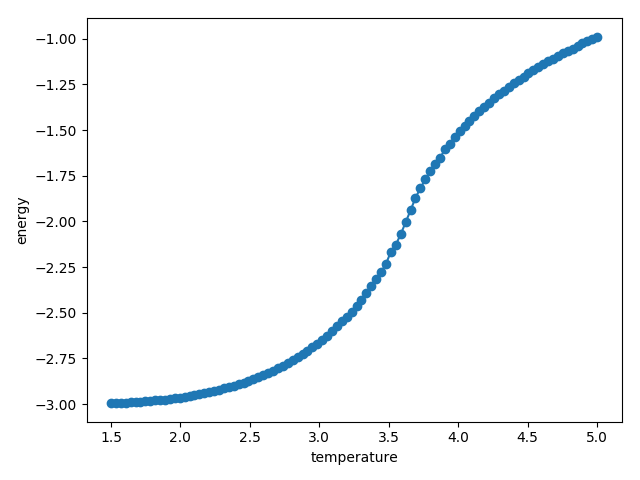

In [8]:
plt.figure()
plt.plot(ts, np.mean(energy, 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('energy')
plt.tight_layout()

<IPython.core.display.Javascript object>


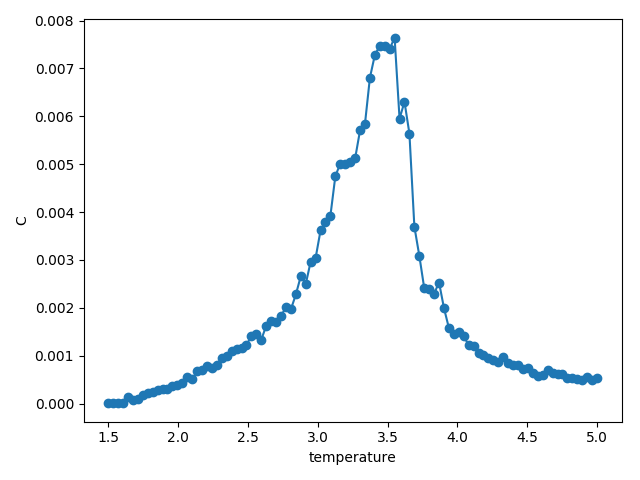

In [9]:
plt.figure()
plt.plot(ts, np.var(energy, 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('C')
plt.tight_layout()

<IPython.core.display.Javascript object>


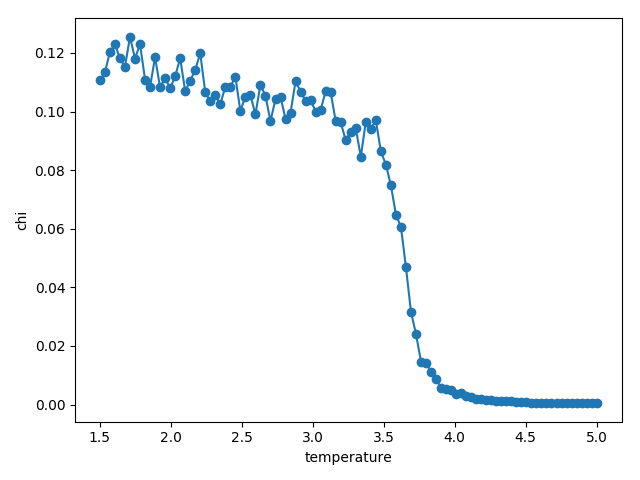

In [13]:
plt.figure()
plt.plot(ts, np.var(np.abs(magnet), 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('chi')
plt.tight_layout()

<IPython.core.display.Javascript object>


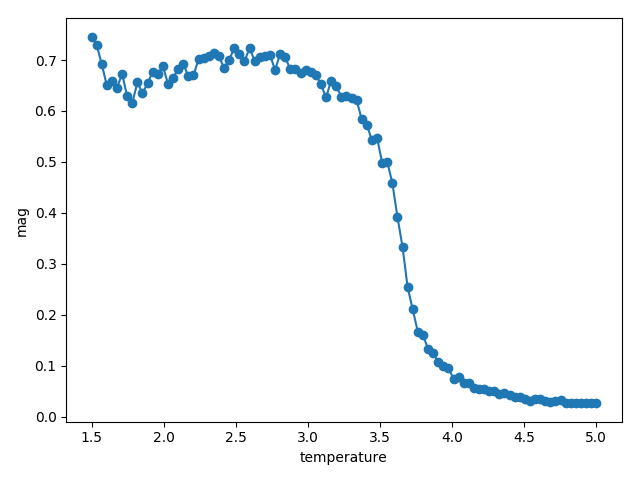

In [15]:
plt.figure()
plt.plot(ts, np.mean(np.abs(magnet), 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('mag')
plt.tight_layout()